### Import Libs :

In [40]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col, corr, mean, max, min, log1p, expm1
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, GBTRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
import pickle

### Create the spark Session:

In [41]:
spark = SparkSession.builder.appName("App").getOrCreate()

### Read Data:

In [42]:
def ReadDataset(file_path):
    df = spark.read.parquet(file_path)
    if df is None:
        raise Exception("Failed to read dataset")
    else :
        return df

file_path = '../data/Silver/'
df = ReadDataset(file_path)
display(df)

DataFrame[VendorID: int, passenger_count: bigint, trip_distance: double, RatecodeID: bigint, store_and_fwd_flag: string, PULocationID: int, DOLocationID: int, payment_type: bigint, fare_amount: double, extra: double, mta_tax: double, tip_amount: double, tolls_amount: double, improvement_surcharge: double, total_amount: double, congestion_surcharge: double, Airport_fee: double, cbd_congestion_fee: double, Durée_minutes: int, pickup_hour: int, pickup_day_week: int, pickup_month: int]

### Shape Data:

In [43]:
print(f"({len(df.columns)},{df.count()})")

(22,2819437)


### encode 'store_and_fwd_flag' column:

In [44]:
# N => 0 | Y => 1
df = df.withColumn("store_and_fwd_flag", when(col("store_and_fwd_flag") == "N", 0).when(col("store_and_fwd_flag") == "Y", 1))
df.show()

+--------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+-------------+-----------+---------------+------------+
|VendorID|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|Durée_minutes|pickup_hour|pickup_day_week|pickup_month|
+--------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+-------------+-----------+---------------+------------+
|       1|              1|          1.6|         1|                 0|         229|         23

In [45]:
test = df.select('pickup_month').distinct()
test.show()

+------------+
|pickup_month|
+------------+
|          12|
|           1|
|           2|
+------------+



### Correlation matrix :

In [46]:
# 1. Get columns
df_cols = df.columns
Data = []

for i, colm1 in enumerate(df_cols):
    for j, colm2 in enumerate(df_cols):
        val = df.select(corr(colm1, colm2)).head(1)[0][0]
        Data.append((colm1, colm2, val))

corr_df = spark.createDataFrame(Data, ["Feature1", "Feature2", "corr_value"])

In [47]:
pd_corr = corr_df.toPandas()
heatmap_df = pd_corr.pivot(index="Feature1", columns="Feature2", values="corr_value")

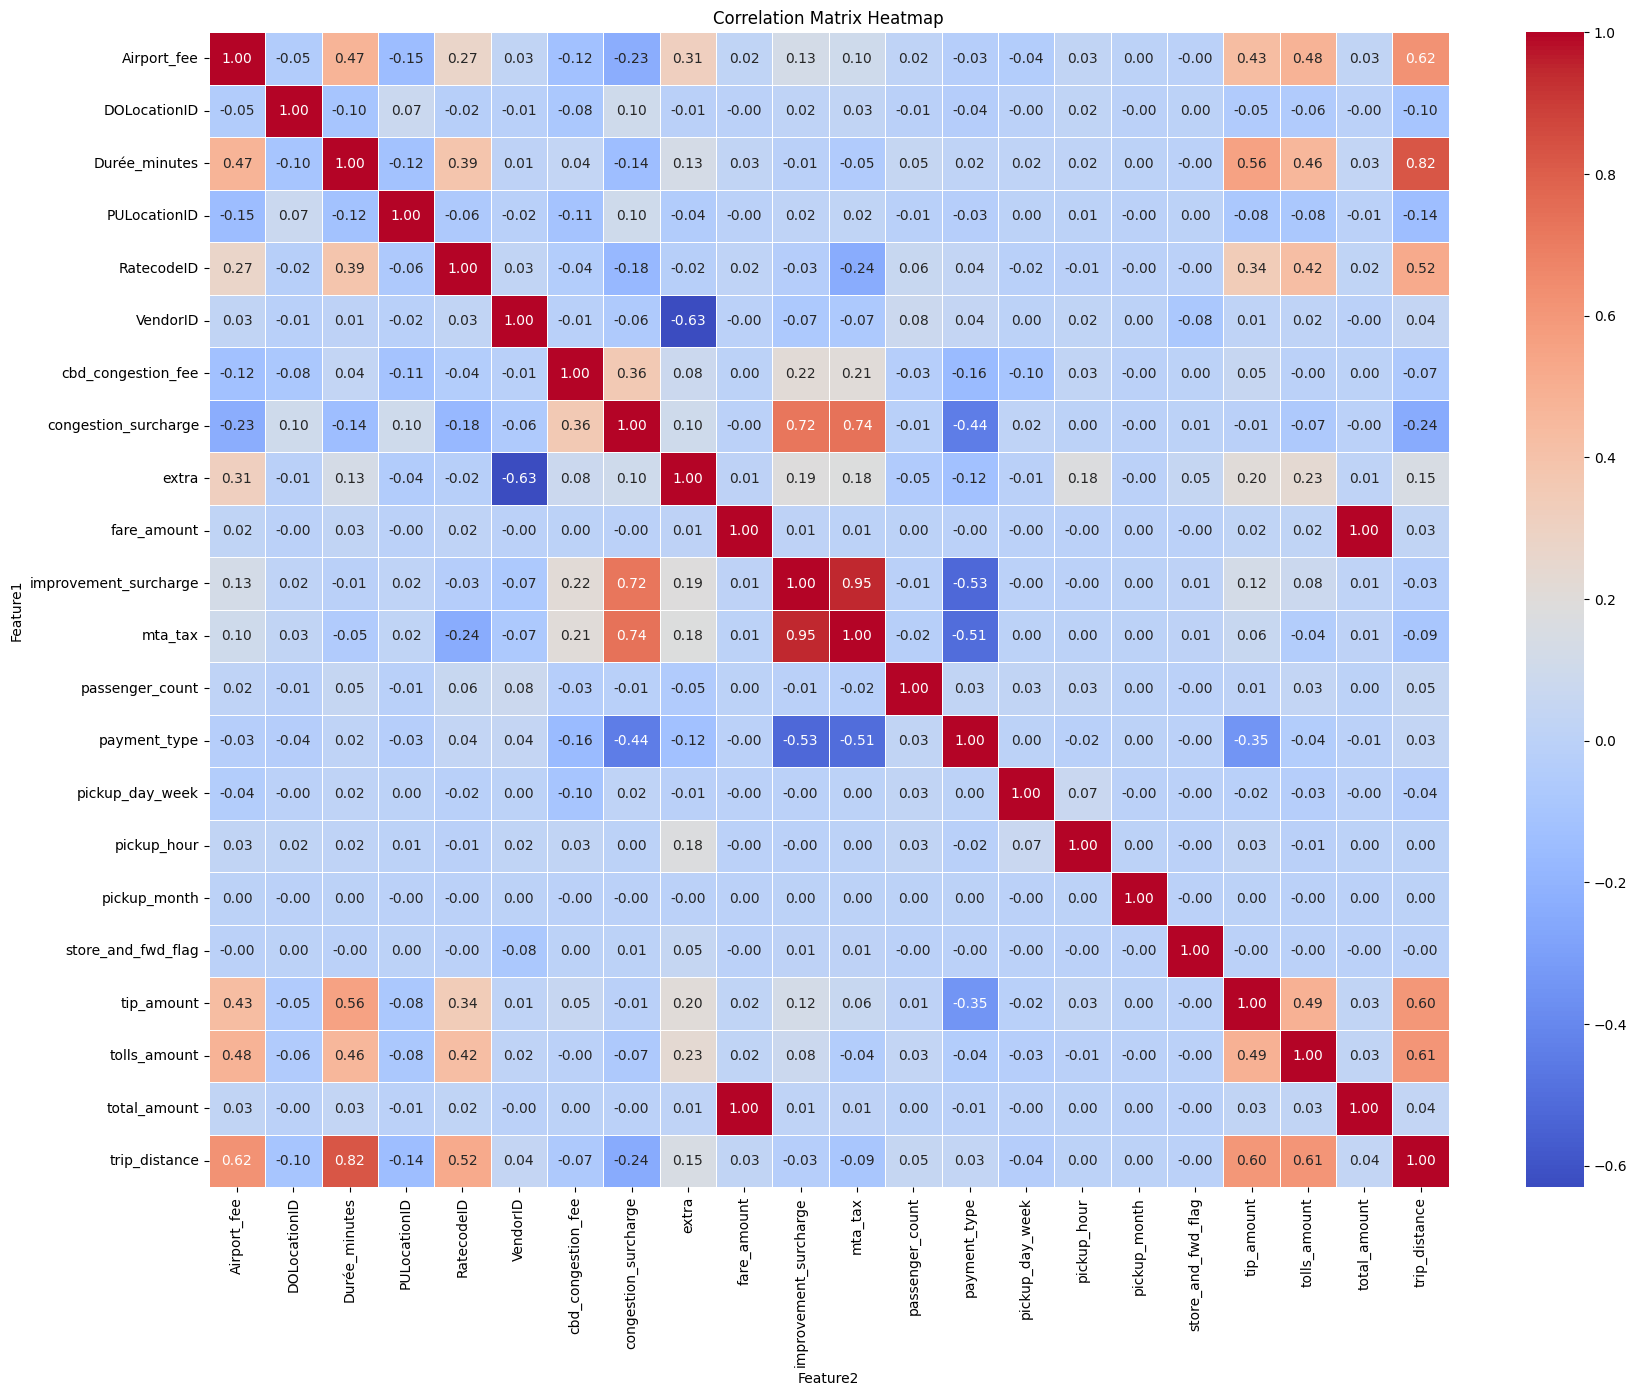

In [48]:
pd_corr = corr_df.toPandas()
heatmap_df = pd_corr.pivot(index="Feature1", columns="Feature2", values="corr_value")

plt.figure(figsize=(20, 15))
sns.heatmap(heatmap_df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

### visualisation:

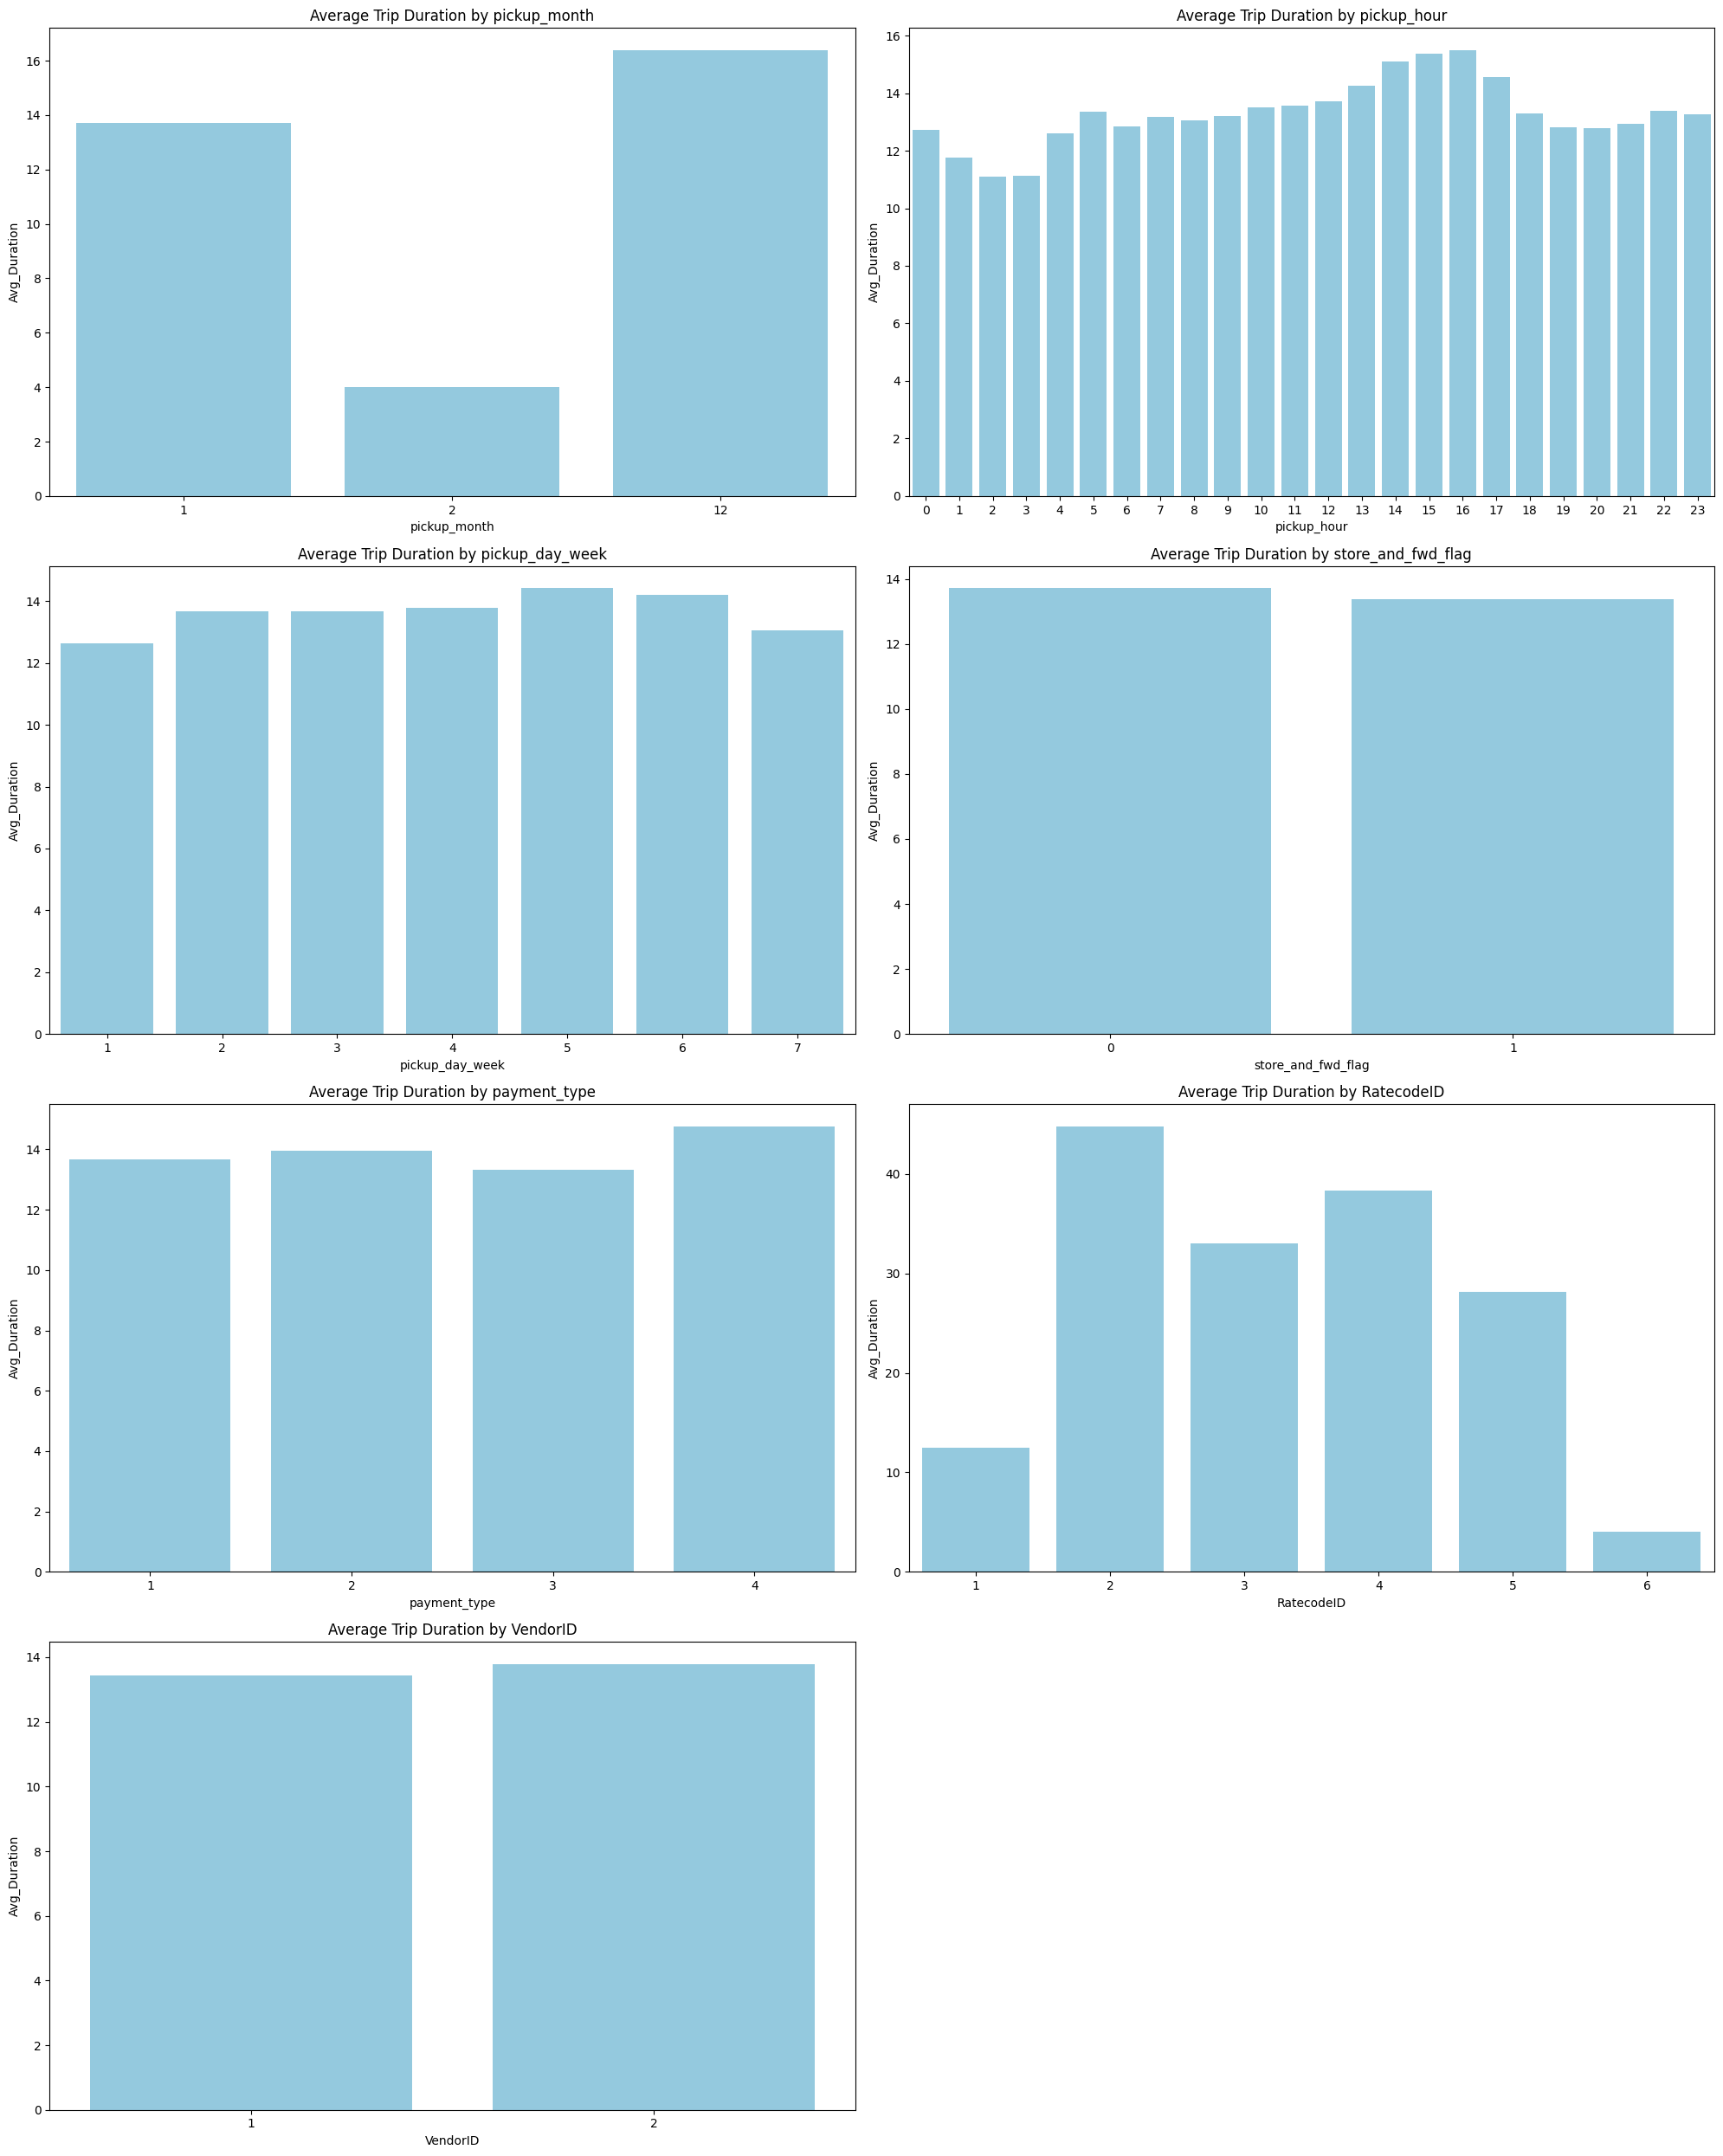

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

Cat_column = ["pickup_month","pickup_hour", "pickup_day_week", "store_and_fwd_flag",'payment_type','RatecodeID','VendorID']

plt.figure(figsize=(20, 25))

for i, colm in enumerate(Cat_column):
    hourly_stats = df.groupBy(colm).agg(mean("Durée_minutes").alias("Avg_Duration")).orderBy(colm)

    hourly_stats_pd = hourly_stats.toPandas()
    
    plt.subplot(4, 2, i+1)
    
    sns.barplot(x=colm, y='Avg_Duration', data=hourly_stats_pd, color='skyblue')
    plt.title(f'Average Trip Duration by {colm}')

plt.tight_layout()
plt.show()

In [50]:
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: integer (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- cbd_congestion_fee: double (nullable = true)
 |-- Durée_minutes: integer (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- pickup_day_week: integer (nullable = true)
 |-- pickup_month: integer (nullable = true)



### Take best Features :

In [51]:
def BestFeatures(Data):
    Best = ["trip_distance", "pickup_hour", "pickup_month", "Airport_fee", "pickup_day_week", "RateCodeID","Durée_minutes"]
    df_drp = df.select(Best)
    return df_drp

df_final = BestFeatures(df)
df_final.printSchema()

root
 |-- trip_distance: double (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- pickup_month: integer (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- pickup_day_week: integer (nullable = true)
 |-- RateCodeID: long (nullable = true)
 |-- Durée_minutes: integer (nullable = true)



### make data in one vector:

In [52]:
def VectorCreation(Data):
    vec_assmebler = VectorAssembler(inputCols=["trip_distance", "pickup_hour", "pickup_month", "Airport_fee", "pickup_day_week", "RateCodeID"], outputCol='Features')
    features_df = vec_assmebler.transform(Data)
    return features_df

features_df = VectorCreation(df_final)
features_df.printSchema()
features_df.select('Features').show(5, False)

root
 |-- trip_distance: double (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- pickup_month: integer (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- pickup_day_week: integer (nullable = true)
 |-- RateCodeID: long (nullable = true)
 |-- Durée_minutes: integer (nullable = true)
 |-- Features: vector (nullable = true)

+--------------------------+
|Features                  |
+--------------------------+
|[1.6,0.0,1.0,0.0,4.0,1.0] |
|[0.5,0.0,1.0,0.0,4.0,1.0] |
|[0.6,0.0,1.0,0.0,4.0,1.0] |
|[0.52,0.0,1.0,0.0,4.0,1.0]|
|[0.66,0.0,1.0,0.0,4.0,1.0]|
+--------------------------+
only showing top 5 rows


In [53]:
#scaler = StandardScaler(inputCol="Features", outputCol="ScaledFeatures")
#scaler_model = scaler.fit(features_df)
#scaled_df = scaler_model.transform(features_df)

#scaled_df.select("Features", "ScaledFeatures").show(5, truncate=False)

### Scale Target:

In [54]:

features_df = features_df.withColumn(
    "Durée_minutes_log",
    log1p(col("Durée_minutes"))
)

features_df.select("Durée_minutes", "Durée_minutes_log").show(5, truncate=False)

+-------------+------------------+
|Durée_minutes|Durée_minutes_log |
+-------------+------------------+
|8            |2.1972245773362196|
|2            |1.0986122886681096|
|1            |0.6931471805599453|
|5            |1.791759469228055 |
|3            |1.3862943611198906|
+-------------+------------------+
only showing top 5 rows


### Verify Scaled Target:

(2819437, 1)


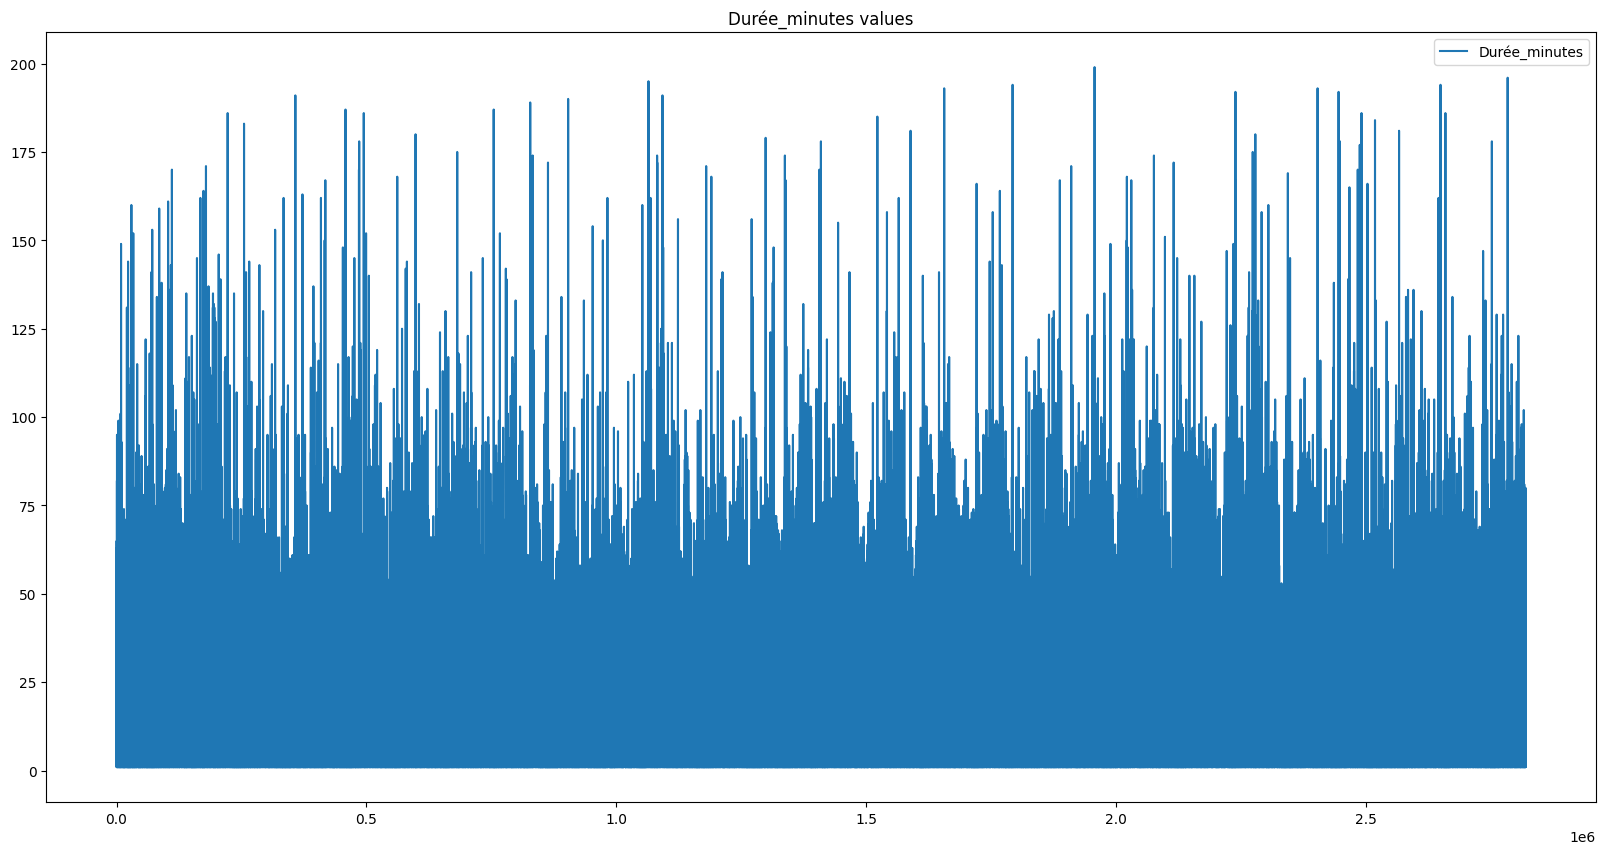

In [55]:
rr = features_df.select("Durée_minutes")
pd_rr = rr.toPandas()
print(pd_rr.shape)
plt.figure(figsize=(20, 10))
sns.lineplot(data=pd_rr)
plt.title("Durée_minutes values")
plt.show()

### Create data containing features and label:

In [56]:
def ModelDfCreator(Data):
    model_df = Data.select("Features","Durée_minutes_log","Durée_minutes")
    return model_df

model_df = ModelDfCreator(features_df)
model_df.printSchema()
model_df.show(5, False)
print(f"Shape : {(model_df.count(), len(model_df.columns))}")

root
 |-- Features: vector (nullable = true)
 |-- Durée_minutes_log: double (nullable = true)
 |-- Durée_minutes: integer (nullable = true)

+--------------------------+------------------+-------------+
|Features                  |Durée_minutes_log |Durée_minutes|
+--------------------------+------------------+-------------+
|[1.6,0.0,1.0,0.0,4.0,1.0] |2.1972245773362196|8            |
|[0.5,0.0,1.0,0.0,4.0,1.0] |1.0986122886681096|2            |
|[0.6,0.0,1.0,0.0,4.0,1.0] |0.6931471805599453|1            |
|[0.52,0.0,1.0,0.0,4.0,1.0]|1.791759469228055 |5            |
|[0.66,0.0,1.0,0.0,4.0,1.0]|1.3862943611198906|3            |
+--------------------------+------------------+-------------+
only showing top 5 rows
Shape : (2819437, 3)


### Split Data - Train and Test :

In [57]:
def SplitData(Data):
    Train_df , Test_df = Data.randomSplit([0.7,0.3])
    return Train_df, Test_df

Train_df, Test_df = SplitData(model_df)
print(f"Shape Train_df : {(Train_df.count(), len(Train_df.columns))}")
print(f"Shape Test_df : {(Test_df.count(), len(Test_df.columns))}")
Test_df.describe().show()
Train_df.describe().show()

Shape Train_df : (1972891, 3)


Shape Test_df : (846546, 3)


+-------+------------------+------------------+
|summary| Durée_minutes_log|     Durée_minutes|
+-------+------------------+------------------+
|  count|            846546|            846546|
|   mean|2.4690692247085155|13.698106186787252|
| stddev|0.6590480779311448|10.818527679184852|
|    min|0.6931471805599453|                 1|
|    max|5.2832037287379885|               196|
+-------+------------------+------------------+



+-------+------------------+------------------+
|summary| Durée_minutes_log|     Durée_minutes|
+-------+------------------+------------------+
|  count|           1972891|           1972891|
|   mean| 2.470149191944797|13.724056220034457|
| stddev|0.6603825530583362| 10.84344341669857|
|    min|0.6931471805599453|                 1|
|    max| 5.298317366548036|               199|
+-------+------------------+------------------+



### Create Linear Regression Model:

In [ ]:
model = LinearRegression(featuresCol="Features", labelCol="Durée_minutes")
lr_model = model.fit(Train_df)
test_result = lr_model.evaluate(Test_df)

26/01/09 07:29:09 WARN Instrumentation: [a397c76c] regParam is zero, which might cause numerical instability and overfitting.


In [59]:
print(f"R2 : {test_result.r2}")
# Model predect 29% of real Predection(R2)
print(f"MAE : {test_result.meanAbsoluteError}")
# Mean Of Error (Mean) (MAE)

R2 : 0.4937112335852163
MAE : 0.3670185344177649


In [ ]:
model2 = GBTRegressor(
    featuresCol="Features",
    labelCol="Durée_minutes"
)
lr_model2 = model2.fit(Train_df)
test_result2 = lr_model2.transform(Test_df)

26/01/09 07:29:35 WARN MemoryStore: Not enough space to cache rdd_8399_1 in memory! (computed 5.4 MiB so far)
26/01/09 07:29:35 WARN BlockManager: Persisting block rdd_8399_1 to disk instead.


In [61]:
test_result2 = test_result2.withColumn(
    "prediction_original",
    expm1(col("prediction"))
)

evaluator_r2 = RegressionEvaluator(
    labelCol="Durée_minutes",
    predictionCol="prediction",
    metricName="r2"
)

evaluator_mae = RegressionEvaluator(
    labelCol="Durée_minutes",
    predictionCol="prediction",
    metricName="mae"
)

r2 = evaluator_r2.evaluate(test_result2)
mae = evaluator_mae.evaluate(test_result2)

print(f"R2 : {r2}")
print(f"MAE : {mae}")

R2 : 0.7974292700375017
MAE : 3.1743581730999915


### Cmpare Predict With Real Vlaues :

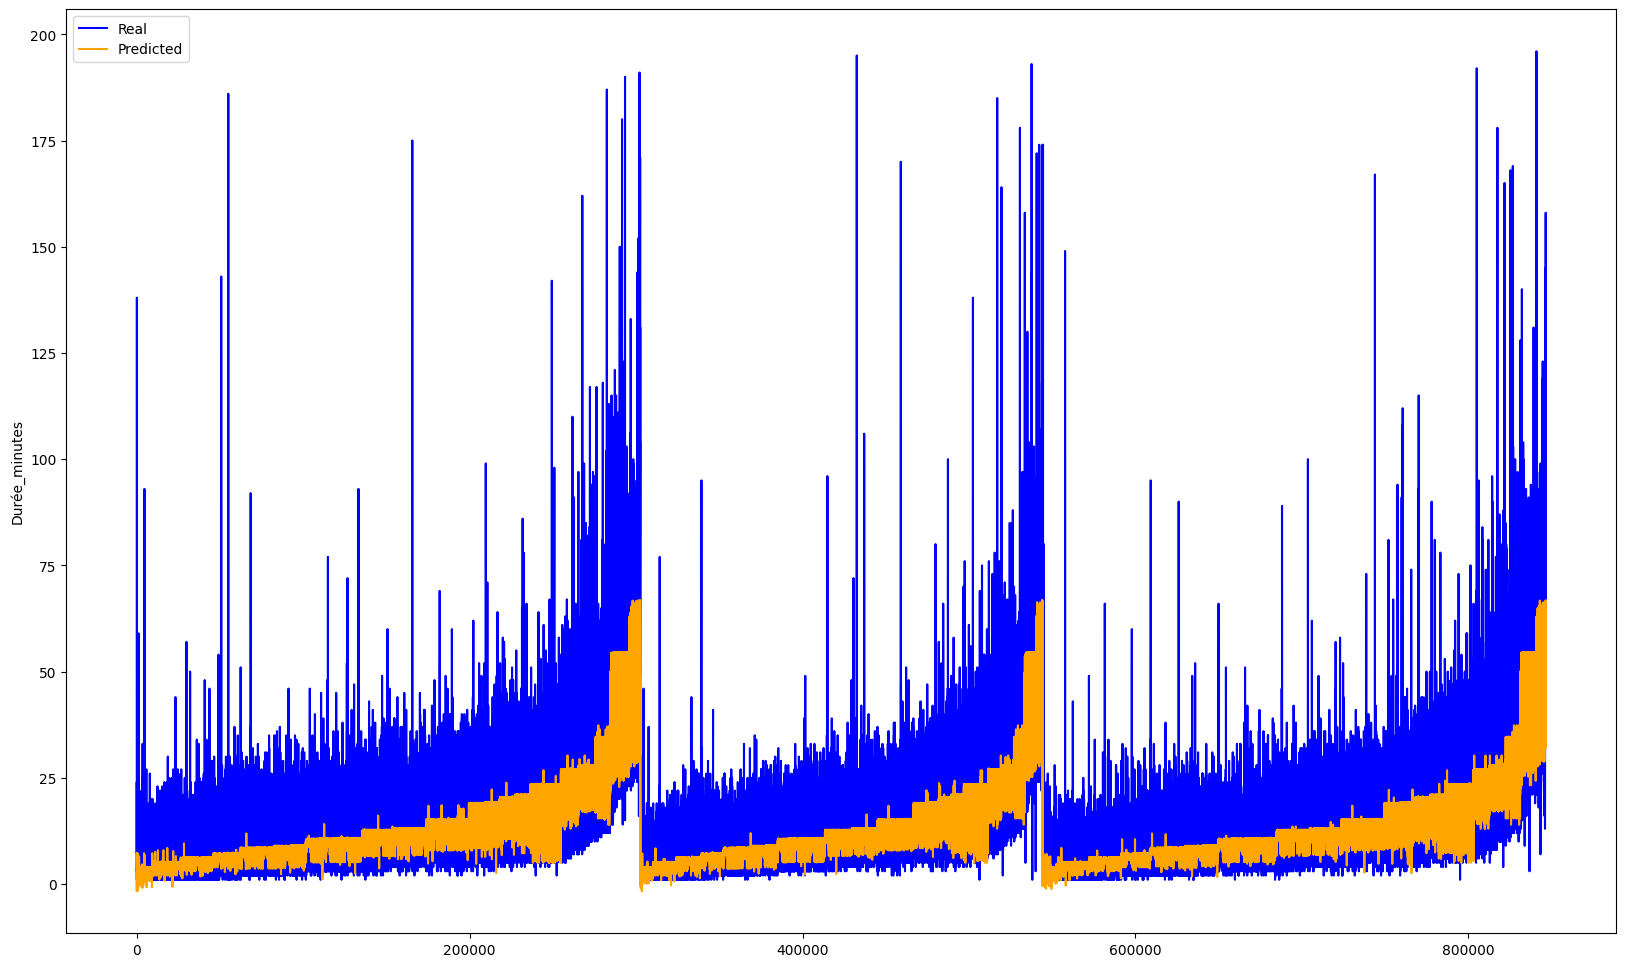

In [62]:
Prediction_values = test_result2.select("prediction").toPandas()["prediction"]
Real_values = Test_df.select('Durée_minutes').toPandas()["Durée_minutes"]

plt.figure(figsize=(20, 12))
sns.lineplot(data= Real_values, label="Real", color="blue")
sns.lineplot(data= Prediction_values, label="Predicted", color="orange")
plt.show()

### Save Modele:

In [63]:
model_path = "../Model/gbt_duration_minutes_v1"
lr_model2.write().overwrite().save(model_path)

### Load Model :

In [64]:
from pyspark.ml.regression import GBTRegressionModel

model_path = "../Model/gbt_duration_minutes_v1"
lr_model_loaded = GBTRegressionModel.load(model_path)

### Test Loaded Model :

In [65]:
preds = lr_model_loaded.transform(Test_df)
preds.select("prediction").show(5)

+-------------------+
|         prediction|
+-------------------+
| 2.8578857661660937|
| 2.8578857661660937|
| 0.9547264184631707|
|-1.6055556324387097|
|-1.7026399292176448|
+-------------------+
only showing top 5 rows
